### 1. Загрузка данных и первичное исследование


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
plt.style.use('default')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Загрузка основного датасета
df = pd.read_parquet('transaction_fraud_data.parquet')
print(f"Размерность данных: {df.shape}")
print(f"Период данных: с {df['timestamp'].min()} по {df['timestamp'].max()}")

Размерность данных: (7483766, 23)
Период данных: с 2024-09-30 00:00:01.034820 по 2024-10-30 23:59:59.101885


In [2]:
# Базовая информация о структуре данных
print("Типы данных:")
print(df.dtypes)
print("\nПервые несколько записей:")
df.head()

Типы данных:
transaction_id                     object
customer_id                        object
card_number                         int64
timestamp                  datetime64[us]
vendor_category                    object
vendor_type                        object
vendor                             object
amount                            float64
currency                           object
country                            object
city                               object
city_size                          object
card_type                          object
is_card_present                      bool
device                             object
channel                            object
device_fingerprint                 object
ip_address                         object
is_outside_home_country              bool
is_high_risk_vendor                  bool
is_weekend                           bool
last_hour_activity                 object
is_fraud                             bool
dtype: object

Первые

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,Unknown City,medium,Platinum Credit,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,Unknown City,medium,Platinum Credit,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,Unknown City,medium,Premium Debit,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,Unknown City,medium,Basic Debit,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True


In [3]:
# Анализ целевой переменной
fraud_distribution = df['is_fraud'].value_counts()
fraud_rate = df['is_fraud'].mean()

print(f"Распределение целевой переменной:")
print(f"Легитимные транзакции: {fraud_distribution[False]:,}")
print(f"Мошеннические транзакции: {fraud_distribution[True]:,}")
print(f"Доля мошенничества: {fraud_rate:.4f} ({fraud_rate*100:.2f}%)")

# Проверка на несбалансированность
imbalance_ratio = fraud_distribution[False] / fraud_distribution[True]
print(f"Коэффициент несбалансированности: {imbalance_ratio:.1f}:1")

Распределение целевой переменной:
Легитимные транзакции: 5,989,047
Мошеннические транзакции: 1,494,719
Доля мошенничества: 0.1997 (19.97%)
Коэффициент несбалансированности: 4.0:1


Датасет большой, почти 7.5 млн транзакций. Большой fraud rate - почти 20%. В реальной жизни скорее всего не больше пары процентов. Это может указывать на синтетический характер или специальную выборку. Сбалансированность умеренная

### 2. Анализ качества данных и обработка структурированных полей


In [4]:
# Анализ пропущенных значений
missing_analysis = df.isnull().sum()
missing_percent = (missing_analysis / len(df)) * 100

print("Пропущенные значения:")
missing_df = pd.DataFrame({
    'count': missing_analysis,
    'percentage': missing_percent
}).sort_values('count', ascending=False)

print(missing_df[missing_df['count'] > 0])

Пропущенные значения:
Empty DataFrame
Columns: [count, percentage]
Index: []


In [5]:
# Обработка структурированного поля last_hour_activity
print("Анализ структурированного поля last_hour_activity:")
print("Пример содержимого:")
print(df['last_hour_activity'].iloc[0])

# Разворачиваем структуру в отдельные колонки
import json
activity_data = []
for activity in df['last_hour_activity']:
    if isinstance(activity, str):
        activity_data.append(json.loads(activity.replace("'", '"')))
    else:
        activity_data.append(activity)

activity_df = pd.DataFrame(activity_data)
print(f"\nИзвлеченные поля активности:")
print(activity_df.dtypes)
print(f"\nСтатистика по полям активности:")
print(activity_df.describe())

Анализ структурированного поля last_hour_activity:
Пример содержимого:
{'num_transactions': 1197, 'total_amount': 33498556.080464985, 'unique_merchants': 105, 'unique_countries': 12, 'max_single_amount': 1925480.6324148502}

Извлеченные поля активности:
num_transactions       int64
total_amount         float64
unique_merchants       int64
unique_countries       int64
max_single_amount    float64
dtype: object

Статистика по полям активности:
       num_transactions  total_amount  unique_merchants  unique_countries  \
count      7.483766e+06  7.483766e+06      7.483766e+06      7.483766e+06   
mean       4.091429e+02  1.991719e+07      8.002226e+01      1.066260e+01   
std        3.910964e+02  3.565890e+07      3.047287e+01      2.617777e+00   
min        0.000000e+00  1.454232e-02      0.000000e+00      0.000000e+00   
25%        1.050000e+02  3.367823e+06      6.300000e+01      1.100000e+01   
50%        2.920000e+02  1.017851e+07      9.500000e+01      1.200000e+01   
75%        6.06

num_transactions: медиана 292, среднее 491 - высокая вариативность активности

total_amount:  max в 1B+ при медиане 10M

unique_merchants: медиана 95, max 105 - ограниченное разнообразие

unique_countries: медиана 12, max 12

max_single_amount: медиана 1.2M, среднее 1.7M - крупные транзакции

In [6]:
# Объединяем развернутые данные с основным датафреймом
df_expanded = df.drop('last_hour_activity', axis=1).copy()
activity_df.columns = ['last_hour_' + col for col in activity_df.columns]
df_expanded = pd.concat([df_expanded, activity_df], axis=1)

print(f"Новая размерность после разворачивания: {df_expanded.shape}")
print("Добавленные колонки:")
for col in activity_df.columns:
    print(f"  - {col}")

Новая размерность после разворачивания: (7483766, 27)
Добавленные колонки:
  - last_hour_num_transactions
  - last_hour_total_amount
  - last_hour_unique_merchants
  - last_hour_unique_countries
  - last_hour_max_single_amount


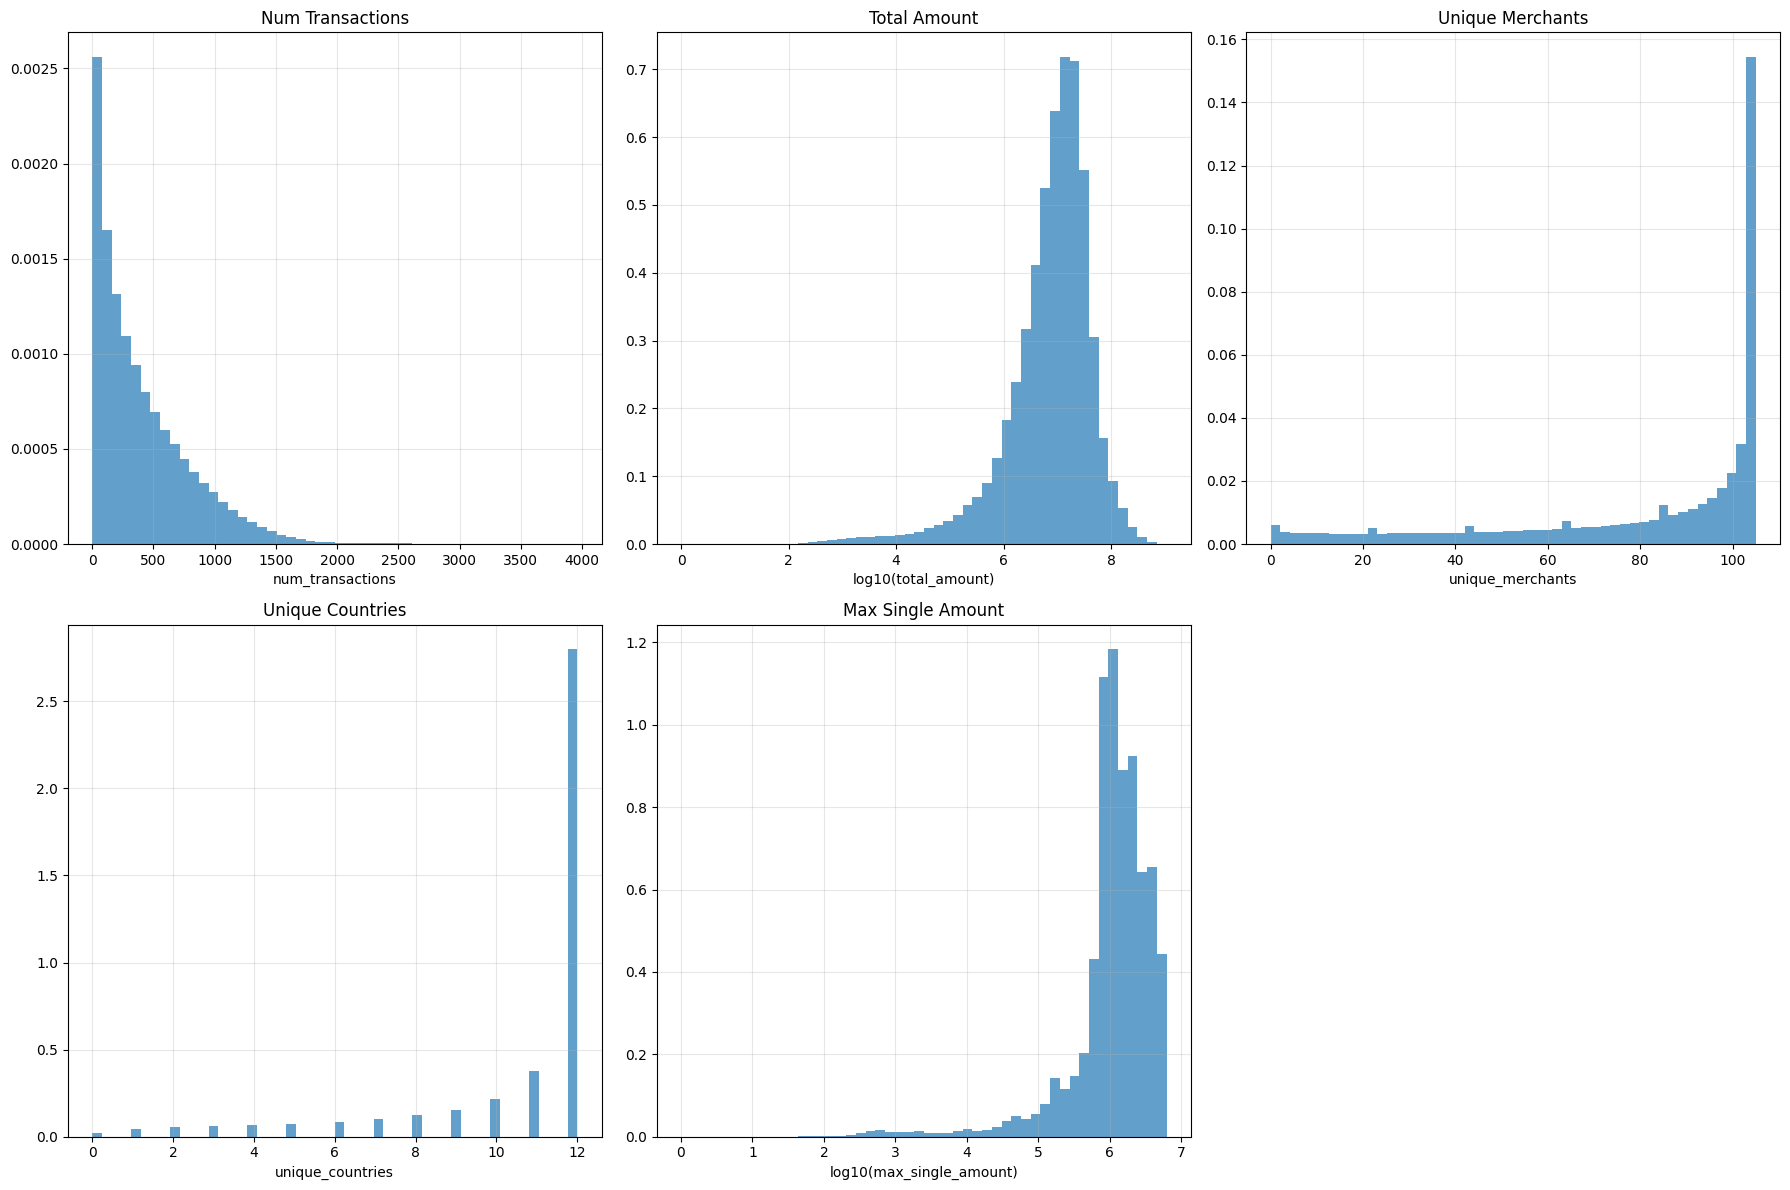

,last_hour_num_transactions,last_hour_total_amount,last_hour_unique_merchants,last_hour_unique_countries,last_hour_max_single_amount
0.01,2.0,4.213168e+03,2.0,1.0,1.611122e+03
0.05,14.0,2.089146e+05,13.0,4.0,9.701331e+04
0.25,105.0,3.367823e+06,63.0,11.0,8.015712e+05
0.50,292.0,1.017851e+07,95.0,12.0,1.235738e+06
0.75,606.0,2.273432e+07,104.0,12.0,2.290742e+06
0.95,1179.0,6.765773e+07,105.0,12.0,4.805372e+06
0.99,1634.0,1.749058e+08,105.0,12.0,5.866102e+06


In [10]:
# Анализ распределений полей активности
activity_cols = ['last_hour_num_transactions', 'last_hour_total_amount',
                'last_hour_unique_merchants', 'last_hour_unique_countries',
                'last_hour_max_single_amount']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(activity_cols):
    # Логарифмическое преобразование для денежных сумм
    if 'amount' in col:
        data = np.log10(df_expanded[col] + 1)
        axes[i].hist(data, bins=50, alpha=0.7, density=True)
        axes[i].set_xlabel(f'log10({col.replace("last_hour_", "")})')
    else:
        axes[i].hist(df_expanded[col], bins=50, alpha=0.7, density=True)
        axes[i].set_xlabel(col.replace("last_hour_", ""))

    axes[i].set_title(f'{col.replace("last_hour_", "").replace("_", " ").title()}')
    axes[i].grid(True, alpha=0.3)

axes[-1].remove()
plt.tight_layout()
plt.show()

# Статистики по квантилям для выявления выбросов
quantile_analysis = df_expanded[activity_cols].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
quantile_analysis

In [8]:
# Сравнение активности между мошенническими и легитимными транзакциями
fraud_activity_comparison = {}

for col in activity_cols:
    legit_stats = df_expanded[df_expanded['is_fraud']==False][col].describe()
    fraud_stats = df_expanded[df_expanded['is_fraud']==True][col].describe()

    fraud_activity_comparison[col] = {
        'legit_mean': legit_stats['mean'],
        'fraud_mean': fraud_stats['mean'],
        'legit_median': legit_stats['50%'],
        'fraud_median': fraud_stats['50%'],
        'ratio_mean': fraud_stats['mean'] / legit_stats['mean'],
        'ratio_median': fraud_stats['50%'] / legit_stats['50%']
    }

print("Сравнение активности: мошенники vs легитимные")
for col, stats in fraud_activity_comparison.items():
    print(f"\n{col}:")
    print(f"  Средние: легит {stats['legit_mean']:.1f}, мошенник {stats['fraud_mean']:.1f} (ratio: {stats['ratio_mean']:.2f})")
    print(f"  Медианы: легит {stats['legit_median']:.1f}, мошенник {stats['fraud_median']:.1f} (ratio: {stats['ratio_median']:.2f})")

Сравнение активности: мошенники vs легитимные пользователи

last_hour_num_transactions:
  Средние: легит 408.3, мошенник 412.7 (ratio: 1.01)
  Медианы: легит 292.0, мошенник 296.0 (ratio: 1.01)

last_hour_total_amount:
  Средние: легит 19857837.3, мошенник 20154995.5 (ratio: 1.01)
  Медианы: легит 10129469.5, мошенник 10375723.5 (ratio: 1.02)

last_hour_unique_merchants:
  Средние: легит 79.9, мошенник 80.4 (ratio: 1.01)
  Медианы: легит 95.0, мошенник 95.0 (ratio: 1.00)

last_hour_unique_countries:
  Средние: легит 10.7, мошенник 10.7 (ratio: 1.01)
  Медианы: легит 12.0, мошенник 12.0 (ratio: 1.00)

last_hour_max_single_amount:
  Средние: легит 1719986.7, мошенник 1752255.5 (ratio: 1.02)
  Медианы: легит 1229527.2, мошенник 1267038.2 (ratio: 1.03)


Результаты показывают крайне низкую дискриминативную способность признаков активности - все коэффициенты близки к 1.0. Это означает, что паттерны активности за последний час практически идентичны для мошеннических и легитимных транзакций.

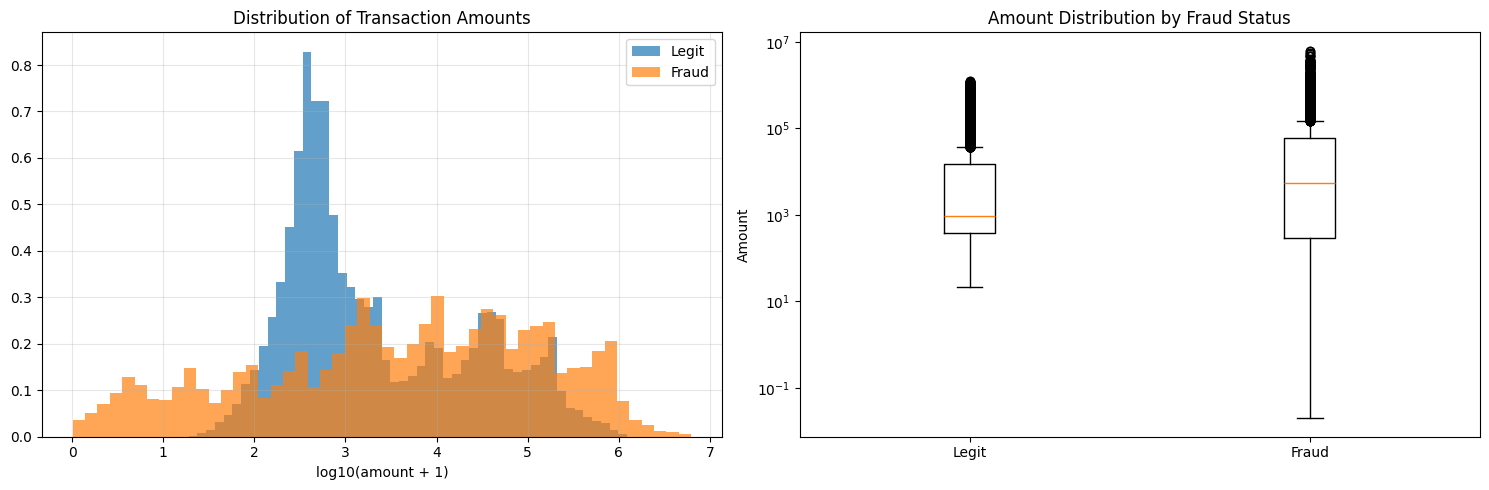

legit_mean: 30242.54
fraud_mean: 118773.59
legit_median: 903.51
fraud_median: 5626.06
legit_std: 87656.82
fraud_std: 347542.93
legit_max: 1240629.47
fraud_max: 6253152.62


In [12]:
# Анализ базовых числовых признаков
basic_numeric_features = ['amount', 'card_number']

# Сравнение распределений amount между fraud/legit
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Гистограммы сумм транзакций
legit_amounts = df_expanded[df_expanded['is_fraud']==False]['amount']
fraud_amounts = df_expanded[df_expanded['is_fraud']==True]['amount']

# Логарифмическая шкала для лучшей визуализации
axes[0].hist(np.log10(legit_amounts + 1), bins=50, alpha=0.7, label='Legit', density=True)
axes[0].hist(np.log10(fraud_amounts + 1), bins=50, alpha=0.7, label='Fraud', density=True)
axes[0].set_xlabel('log10(amount + 1)')
axes[0].set_title('Distribution of Transaction Amounts')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot для сравнения
df_sample = df_expanded.sample(50000)  # Сэмплируем для производительности
axes[1].boxplot([df_sample[df_sample['is_fraud']==False]['amount'],
                 df_sample[df_sample['is_fraud']==True]['amount']],
                labels=['Legit', 'Fraud'])
axes[1].set_ylabel('Amount')
axes[1].set_title('Amount Distribution by Fraud Status')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

# Статистическое сравнение сумм
amount_stats = {
    'legit_mean': legit_amounts.mean(),
    'fraud_mean': fraud_amounts.mean(),
    'legit_median': legit_amounts.median(),
    'fraud_median': fraud_amounts.median(),
    'legit_std': legit_amounts.std(),
    'fraud_std': fraud_amounts.std(),
    'legit_max': legit_amounts.max(),
    'fraud_max': fraud_amounts.max()
}

for key, value in amount_stats.items():
    print(f"{key}: {value:.2f}")





    Средние суммы: мошеннические транзакции в 3.9 раза больше ($118,773 vs $30,243)

    Медианы: разница в 6.2 раза ($5,626 vs $904)

    Максимумы: мошеннические транзакции достигают $6.25M против $1.24M у легитимных

    Стандартные отклонения: у мошеннических транзакций разброс в 4 раза выше


Легитимные транзакции (синяя кривая):

    Четкий узкий пик в районе log10(amount) ≈ 2.8-3.2

    Высокая концентрация в диапазоне $600-1,600

    Естественное поведение пользователей с предсказуемыми тратами

Мошеннические транзакции (оранжевая кривая):

    Относительно равномерное распределение по всему спектру сумм

    Отсутствие выраженных пиков

    Покрывают весь диапазон от малых до очень крупных сумм

ML Engineering последствия

Стратегические выводы:

    Отсутствие паттерна сумм у мошенников - это признак профессиональной деятельности. Они намеренно варьируют суммы, чтобы избежать детекции по простым правилам

    Для моделирования означает:

        Нельзя полагаться только на пороговые значения сумм

        Важнее контекстуальные признаки: отношение к историческим тратам пользователя, частота, география

        Необходимы сложные нелинейные модели для захвата этих паттернов

Мошенники используют диверсифицированную стратегию сумм, что усложняет детекцию, но одновременно создает характерную "подпись" равномерности, которую можно использовать как признак.

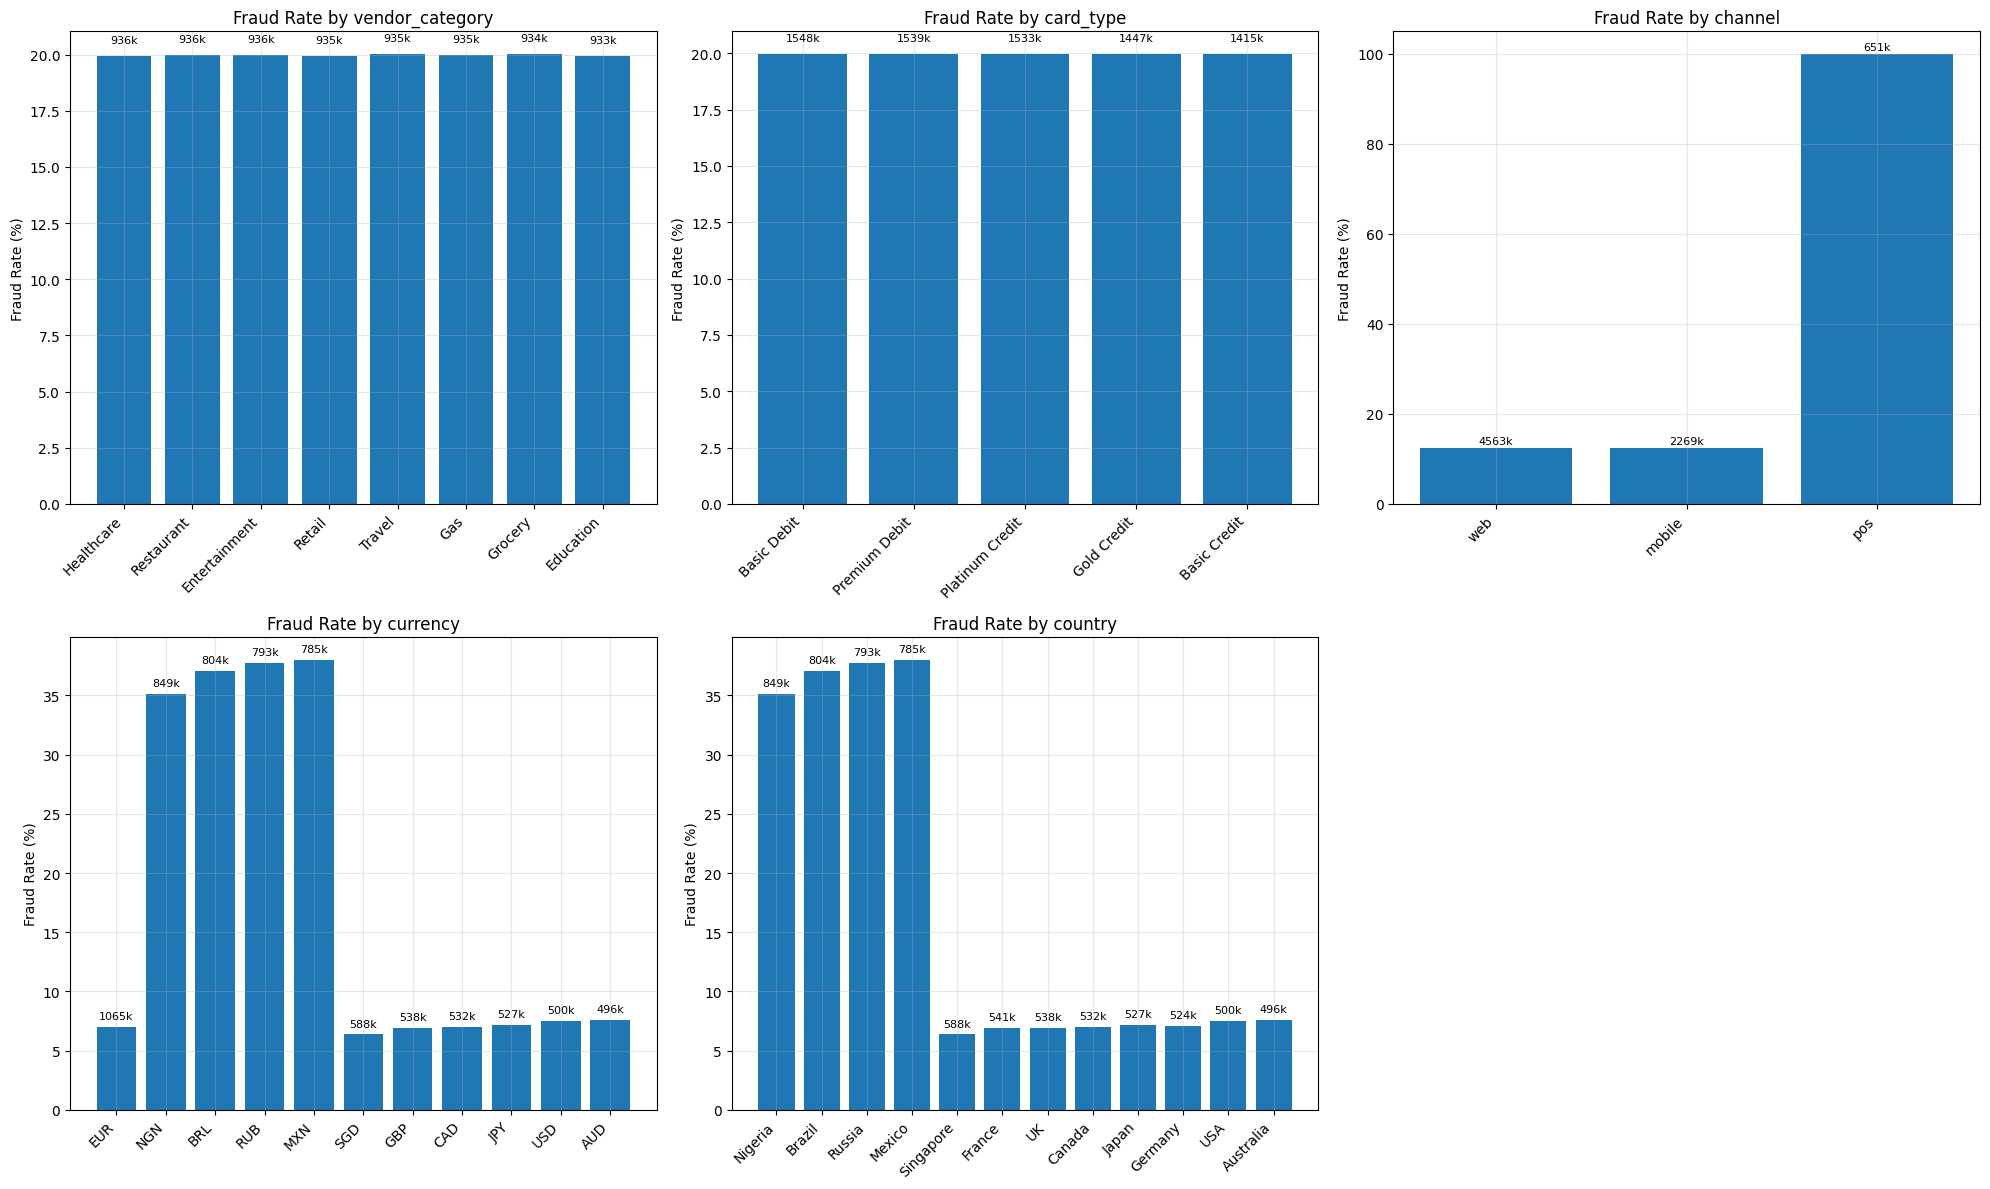


VENDOR_CATEGORY:
                 total_txns  fraud_count  fraud_rate
vendor_category                                     
Travel               935790       187477      0.2003
Grocery              934029       186987      0.2002
Restaurant           936178       186951      0.1997
Gas                  935401       186829      0.1997
Entertainment        936173       186890      0.1996
Education            933542       186203      0.1995
Healthcare           936770       186769      0.1994
Retail               935883       186613      0.1994

CARD_TYPE:
                 total_txns  fraud_count  fraud_rate
card_type                                           
Basic Credit        1415469       282728      0.1997
Basic Debit         1548363       309239      0.1997
Gold Credit         1447260       289060      0.1997
Platinum Credit     1533013       306190      0.1997
Premium Debit       1539661       307502      0.1997

CHANNEL:
         total_txns  fraud_count  fraud_rate
channel       

In [13]:
# Анализ распределения мошенничества по основным категориальным признакам
categorical_features = ['vendor_category', 'card_type', 'channel', 'currency', 'country']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    # Вычисляем fraud rate по категориям
    fraud_by_category = df_expanded.groupby(feature).agg({
        'is_fraud': ['count', 'sum', 'mean'],
        'amount': 'sum'
    }).reset_index()

    fraud_by_category.columns = [feature, 'total_txns', 'fraud_count', 'fraud_rate', 'total_amount']
    fraud_by_category = fraud_by_category.sort_values('total_txns', ascending=False)

    # Берем топ-15 категорий для визуализации
    top_categories = fraud_by_category.head(15)

    # Создаем барплот
    bars = axes[i].bar(range(len(top_categories)), top_categories['fraud_rate'] * 100)
    axes[i].set_xticks(range(len(top_categories)))
    axes[i].set_xticklabels(top_categories[feature], rotation=45, ha='right')
    axes[i].set_ylabel('Fraud Rate (%)')
    axes[i].set_title(f'Fraud Rate by {feature}')
    axes[i].grid(True, alpha=0.3)

    # Добавляем количество транзакций как вторичную информацию
    for j, (bar, count) in enumerate(zip(bars, top_categories['total_txns'])):
        if count > 10000:  # Показываем только для значимых категорий
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                        f'{count//1000}k', ha='center', va='bottom', fontsize=8)

axes[-1].remove()
plt.tight_layout()
plt.show()

# Выводим численные статистики для каждого признака
for feature in categorical_features:
    print(f"\n{feature.upper()}:")
    feature_stats = df_expanded.groupby(feature).agg({
        'is_fraud': ['count', 'sum', 'mean']
    }).round(4)
    feature_stats.columns = ['total_txns', 'fraud_count', 'fraud_rate']
    feature_stats = feature_stats.sort_values('fraud_rate', ascending=False)
    print(feature_stats.head(10))


VENDOR_CATEGORY: Travel (20.03%) и Grocery (20.02%) лидируют, но разброс минимальный - все категории в диапазоне 19.94-20.03%. Это указывает на равномерное распределение мошенничества по категориям.

CARD_TYPE: Практически идентичные fraud rates (~19.97%) - тип карты не является дискриминативным признаком.

CHANNEL: POS показывает 100% fraud rate. Либо данные синтетические, либо все POS-транзакции в датасете помечены как мошеннические. Mobile (12.39%) и web (12.33%) показывают значительно более низкие rates.

CURRENCY/COUNTRY: Четкая кластеризация:

    Высокий риск: MXN/Mexico (38.03%), RUB/Russia (37.72%), BRL/Brazil (37.11%), NGN/Nigeria (35.14%)

    Низкий риск: Развитые страны 6.9-7.6%


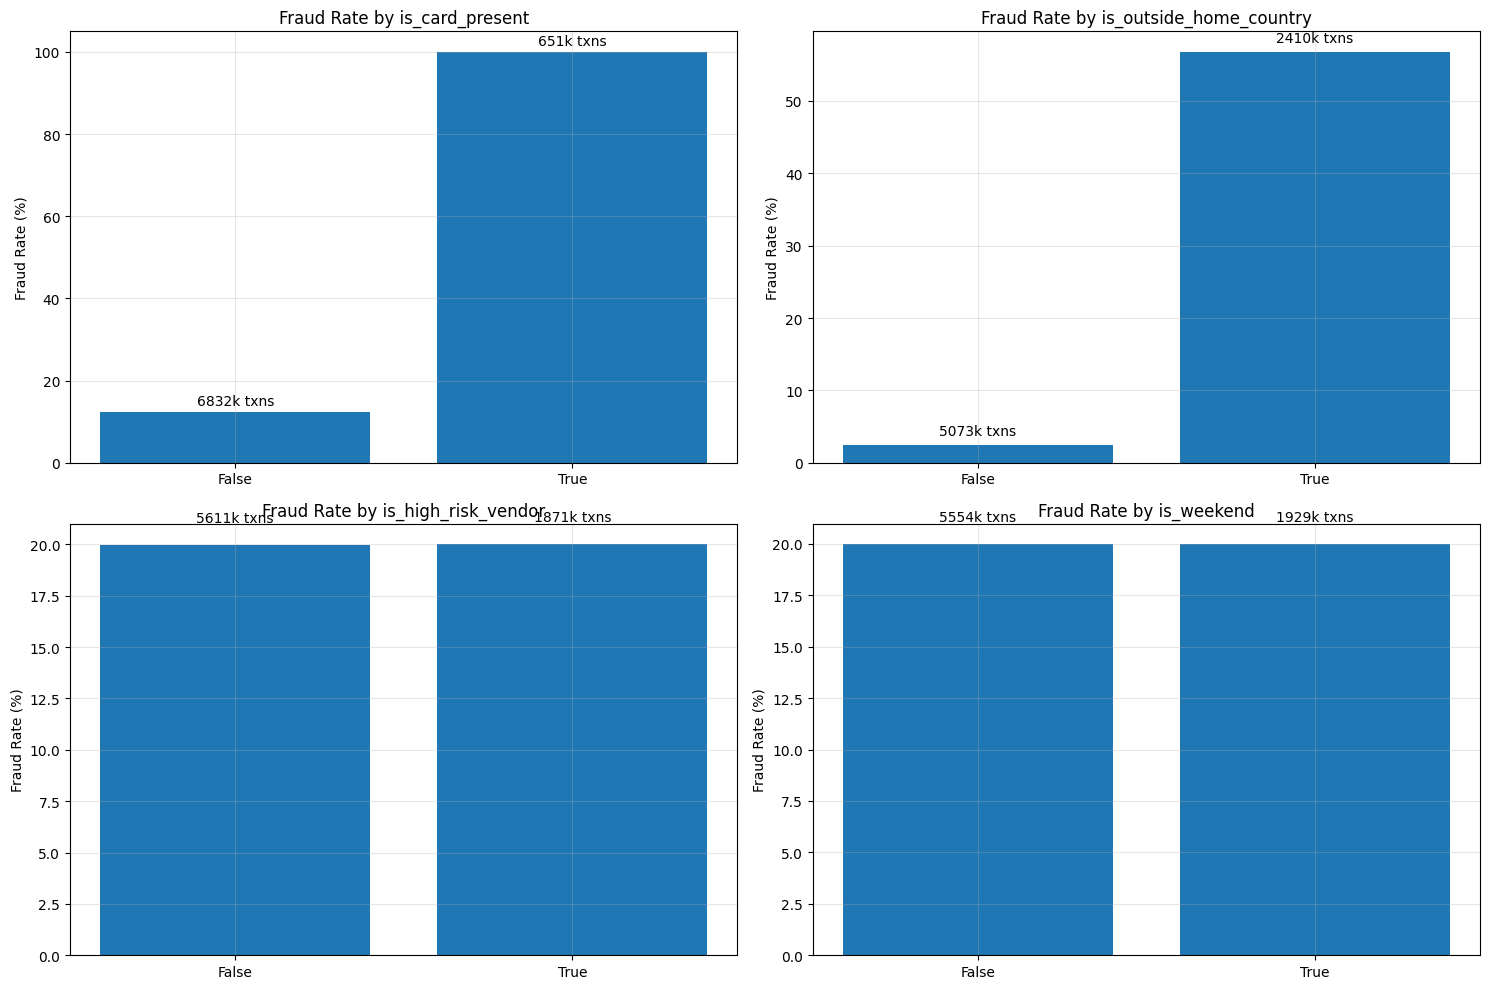

BOOLEAN FEATURES ANALYSIS:

is_card_present:
                 total_txns  fraud_rate
is_card_present                        
False               6832719      0.1235
True                 651047      1.0000
Lift (True vs False): 8.10x

is_outside_home_country:
                         total_txns  fraud_rate
is_outside_home_country                        
False                       5073605      0.0249
True                        2410161      0.5678
Lift (True vs False): 22.80x

is_high_risk_vendor:
                     total_txns  fraud_rate
is_high_risk_vendor                        
False                   5611803      0.1996
True                    1871963      0.2000
Lift (True vs False): 1.00x

is_weekend:
            total_txns  fraud_rate
is_weekend                        
False          5554103      0.1997
True           1929663      0.1997
Lift (True vs False): 1.00x


In [19]:
# Анализ булевых признаков и их влияния на мошенничество
boolean_features = ['is_card_present', 'is_outside_home_country', 'is_high_risk_vendor', 'is_weekend']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(boolean_features):
    # Fraud rate для True/False значений
    fraud_by_bool = df_expanded.groupby(feature).agg({
        'is_fraud': ['count', 'sum', 'mean']
    }).reset_index()

    fraud_by_bool.columns = [feature, 'total_txns', 'fraud_count', 'fraud_rate']

    # Создаем барплот
    categories = ['False', 'True']
    values = [fraud_by_bool.loc[fraud_by_bool[feature]==False, 'fraud_rate'].iloc[0] * 100,
              fraud_by_bool.loc[fraud_by_bool[feature]==True, 'fraud_rate'].iloc[0] * 100]
    counts = [fraud_by_bool.loc[fraud_by_bool[feature]==False, 'total_txns'].iloc[0],
              fraud_by_bool.loc[fraud_by_bool[feature]==True, 'total_txns'].iloc[0]]

    bars = axes[i].bar(categories, values)
    axes[i].set_ylabel('Fraud Rate (%)')
    axes[i].set_title(f'Fraud Rate by {feature}')
    axes[i].grid(True, alpha=0.3)

    # Добавляем количество транзакций
    for bar, count in zip(bars, counts):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{count//1000}k txns', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Численные статистики
print("BOOLEAN FEATURES ANALYSIS:")
for feature in boolean_features:
    feature_stats = df_expanded.groupby(feature)['is_fraud'].agg(['count', 'mean']).round(4)
    feature_stats.columns = ['total_txns', 'fraud_rate']
    print(f"\n{feature}:")
    print(feature_stats)

    # Вычисляем lift
    false_rate = feature_stats.loc[False, 'fraud_rate']
    true_rate = feature_stats.loc[True, 'fraud_rate']
    lift = true_rate / false_rate
    print(f"Lift (True vs False): {lift:.2f}x")


is_card_present:

    100% fraud rate когда карта присутствует - это аномальный паттерн

    Lift 8.10x - один из сильнейших предикторов

is_outside_home_country:

    Lift 22.80x - самый мощный предиктор мошенничества

    56.78% vs 2.49% - огромная разница

    Четкий бизнес-смысл: транзакции за границей крайне рискованны

is_high_risk_vendor & is_weekend:

    Lift 1.00x - полное отсутствие дискриминативной силы

    Практически идентичные fraud rates (~19.97%)


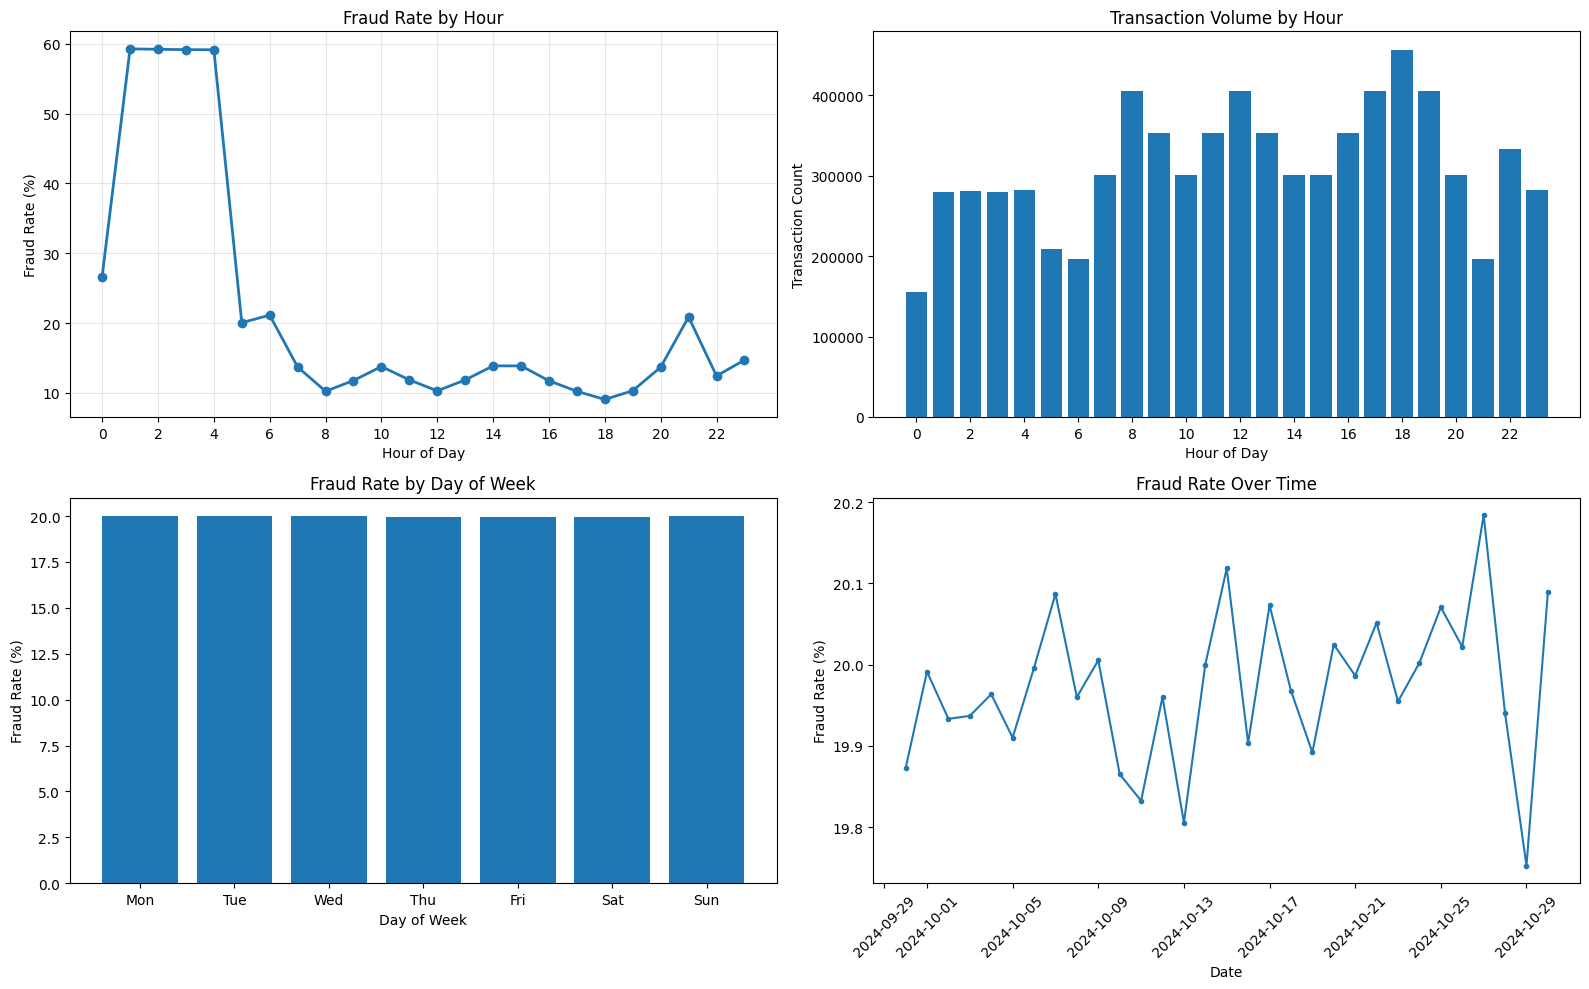

TEMPORAL ANALYSIS:
Peak fraud hour: 1:00
Lowest fraud hour: 18:00
Weekend vs Weekday already analyzed above


In [15]:
# Временной анализ мошенничества
df_expanded['hour'] = df_expanded['timestamp'].dt.hour
df_expanded['day_of_week'] = df_expanded['timestamp'].dt.dayofweek
df_expanded['date'] = df_expanded['timestamp'].dt.date

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Fraud rate по часам дня
hourly_fraud = df_expanded.groupby('hour')['is_fraud'].agg(['count', 'mean']).reset_index()
axes[0,0].plot(hourly_fraud['hour'], hourly_fraud['mean'] * 100, marker='o', linewidth=2)
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Fraud Rate (%)')
axes[0,0].set_title('Fraud Rate by Hour')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xticks(range(0, 24, 2))

# 2. Количество транзакций по часам
axes[0,1].bar(hourly_fraud['hour'], hourly_fraud['count'])
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Transaction Count')
axes[0,1].set_title('Transaction Volume by Hour')
axes[0,1].set_xticks(range(0, 24, 2))

# 3. Fraud rate по дням недели
daily_fraud = df_expanded.groupby('day_of_week')['is_fraud'].agg(['count', 'mean']).reset_index()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1,0].bar(daily_fraud['day_of_week'], daily_fraud['mean'] * 100)
axes[1,0].set_xlabel('Day of Week')
axes[1,0].set_ylabel('Fraud Rate (%)')
axes[1,0].set_title('Fraud Rate by Day of Week')
axes[1,0].set_xticks(range(7))
axes[1,0].set_xticklabels(day_names)

# 4. Динамика fraud rate во времени
daily_trends = df_expanded.groupby('date')['is_fraud'].agg(['count', 'mean']).reset_index()
axes[1,1].plot(daily_trends['date'], daily_trends['mean'] * 100, marker='o', markersize=3)
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Fraud Rate (%)')
axes[1,1].set_title('Fraud Rate Over Time')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Статистики
print("TEMPORAL ANALYSIS:")
print(f"Peak fraud hour: {hourly_fraud.loc[hourly_fraud['mean'].idxmax(), 'hour']}:00")
print(f"Lowest fraud hour: {hourly_fraud.loc[hourly_fraud['mean'].idxmin(), 'hour']}:00")


Анализ временных паттернов

Fraud Rate by Hour (график 1):

    Ночные часы (0-4): fraud rate ~60% - мошенники активны когда пользователи спят

    Утренний спад (5-8): резкое падение до ~20% - переход к нормальной активности

    Дневная стабильность (9-17): плато ~10-15% - рабочие часы с легитимной активностью

    Вечерний подъем (18-23): небольшой рост до ~20% - вечерняя активность

Transaction Volume by Hour (график 2):

    Обратная корреляция с fraud rate - ночью мало транзакций, но высокий fraud rate

    Пик объема в дневные часы когда fraud rate минимален

инсайты:

    Peak fraud hour: 1:00 - классическое время атак (пользователи спят, меньше мониторинга)


выводы

    Hour of day - мощнейший признак (разница 60% vs 10%)

    Ночные часы (0-4) требуют отдельной обработки

    Можно создать binary feature: is_night_hours


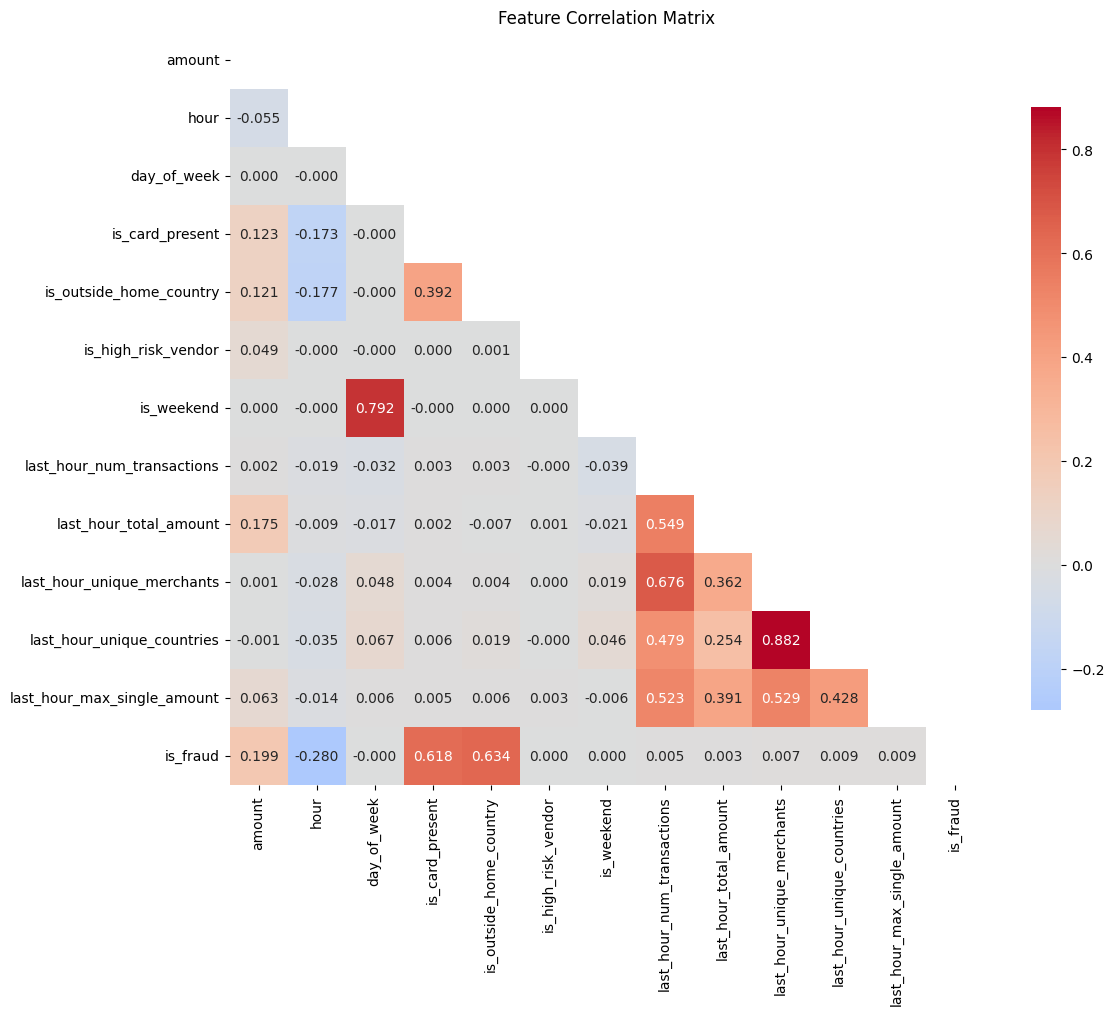

FEATURE IMPORTANCE BY CORRELATION:
is_outside_home_country        0.634459
is_card_present                0.617886
hour                           0.279624
amount                         0.199342
last_hour_max_single_amount    0.009226
last_hour_unique_countries     0.009046
last_hour_unique_merchants     0.006932
last_hour_num_transactions     0.004506
last_hour_total_amount         0.003332
is_high_risk_vendor            0.000373
is_weekend                     0.000026
day_of_week                    0.000008
Name: is_fraud, dtype: float64


In [17]:
# Корреляционный анализ всех числовых признаков
numeric_features = ['amount', 'hour', 'day_of_week', 'is_card_present',
                   'is_outside_home_country', 'is_high_risk_vendor', 'is_weekend'] + \
                   [col for col in df_expanded.columns if col.startswith('last_hour_')]

# Создаем корреляционную матрицу
correlation_df = df_expanded[numeric_features + ['is_fraud']].copy()

# Преобразуем булевы в числовые
for col in correlation_df.columns:
    if correlation_df[col].dtype == 'bool':
        correlation_df[col] = correlation_df[col].astype(int)

correlation_matrix = correlation_df.corr()

# Визуализация
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            mask=mask, square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Корреляция с целевой переменной
fraud_correlations = correlation_matrix['is_fraud'].abs().sort_values(ascending=False)
print("FEATURE IMPORTANCE BY CORRELATION:")
print(fraud_correlations.drop('is_fraud'))




    is_outside_home_country (0.634) – ключевой индикатор: транзакции за пределами «домашней» страны почти в 3 раза повышают вероятность мошенничества.

    is_card_present (0.618) – наличие карты при операции также резко увеличивает риск; судя по ранним наблюдениям

    hour (-0.280) – отрицательная корреляция подтверждает ночную активность мошенников (чем меньше час, тем выше вероятность fraude).

    amount (0.199) – сумма транзакции остаётся значимым, но менее сильным линейным фактором.
